# Preparation

### Import, constants and functions

In [89]:
import numpy as np
from numpy.random import seed
#seed(12345)

import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from google.colab import drive
from google.colab.patches import cv2_imshow

In [90]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [91]:
def show_results(history):
  # Show training history (this cell is complete, nothing to implement here :-) )
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                            epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

In [92]:
def comparison(test_dataset, decoded_imgs, n):
  for ii in range(n):
      image_num = np.random.randint(0, len(test_dataset))

      plt.subplot(2,n,ii+1), plt.imshow(test_dataset[image_num, ...])
      plt.title("original")

      plt.subplot(2,n,ii+1+n), plt.imshow(decoded_imgs[image_num, ...])
      plt.title("reconstructed")

In [93]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [94]:
# Load data from the folder
with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data/train_dataset.npy', 'rb') as f:
    train_dataset = np.load(f)

with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data/test_dataset.npy', 'rb') as f:
    test_dataset = np.load(f)

In [95]:
hight = train_dataset.shape[1]
width = train_dataset.shape[2]

### Data inspaction

In [96]:
print('Train set:   ', len(train_dataset), 'samples')
print('Test set:    ', len(test_dataset), 'samples')
print('Sample dims: ', train_dataset.shape)

Train set:    4310 samples
Test set:     1437 samples
Sample dims:  (4310, 54, 96, 3)


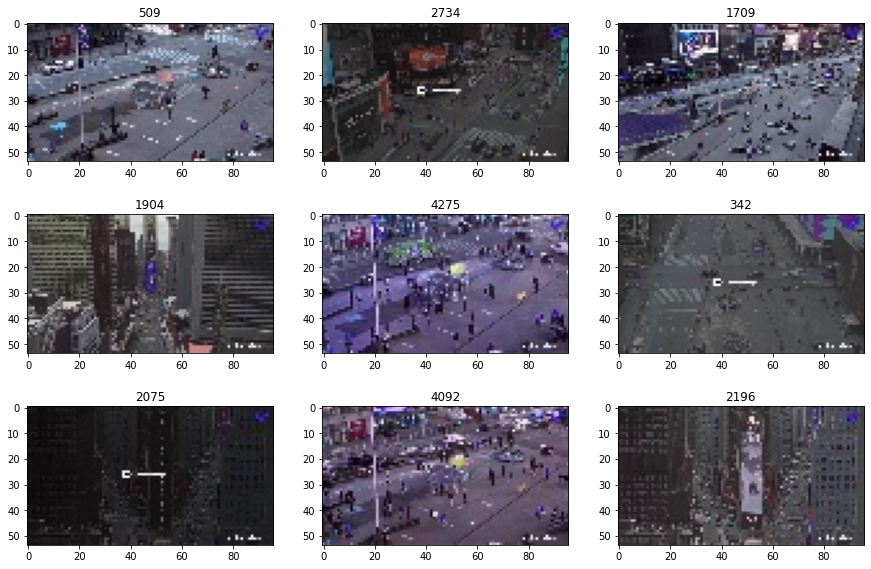

In [97]:
# Show random samples
for ii in range(9):
    image_num = np.random.randint(0, len(train_dataset))
    plt.subplot(3,3,ii+1), plt.imshow(train_dataset[image_num, ...])
    plt.title(str(image_num))

#Building model

In [98]:
# Normalization
train_dataset = train_dataset.astype('float32')/255
test_dataset = test_dataset.astype('float32')/255

## Create model

In [99]:
latent_dim = 1000 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([        
        layers.Dense(width*hight*3, activation='sigmoid'),
        layers.Reshape((hight, width, 3)),
        layers.Conv2DTranspose(3, kernel_size=(3, 3), activation="relu", padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [100]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=["accuracy"])

In [101]:
epochs = 50
batch_size = 16
history = autoencoder.fit(DataGenerator(train_dataset, train_dataset, batch_size),
                epochs=epochs,
                shuffle=True,
                validation_data=(DataGenerator(test_dataset, test_dataset, batch_size)))

Epoch 1/50
270/270 [==============================] - 47s 173ms/step - loss: 0.0307 - accuracy: 0.4950 - val_loss: 0.0145 - val_accuracy: 0.5544
Epoch 2/50
270/270 [==============================] - 46s 172ms/step - loss: 0.0118 - accuracy: 0.5935 - val_loss: 0.0104 - val_accuracy: 0.6016
Epoch 3/50
270/270 [==============================] - 46s 172ms/step - loss: 0.0094 - accuracy: 0.6375 - val_loss: 0.0086 - val_accuracy: 0.6457
Epoch 4/50
270/270 [==============================] - 46s 171ms/step - loss: 0.0084 - accuracy: 0.6631 - val_loss: 0.0083 - val_accuracy: 0.6405
Epoch 5/50
270/270 [==============================] - 46s 172ms/step - loss: 0.0080 - accuracy: 0.6759 - val_loss: 0.0076 - val_accuracy: 0.6644
Epoch 6/50
270/270 [==============================] - 47s 172ms/step - loss: 0.0070 - accuracy: 0.7004 - val_loss: 0.0070 - val_accuracy: 0.7252
Epoch 7/50
270/270 [==============================] - 47s 175ms/step - loss: 0.0068 - accuracy: 0.7148 - val_loss: 0.0069 - val_ac

Train Acc      0.8185387253761292
Validation Acc 0.8285455703735352


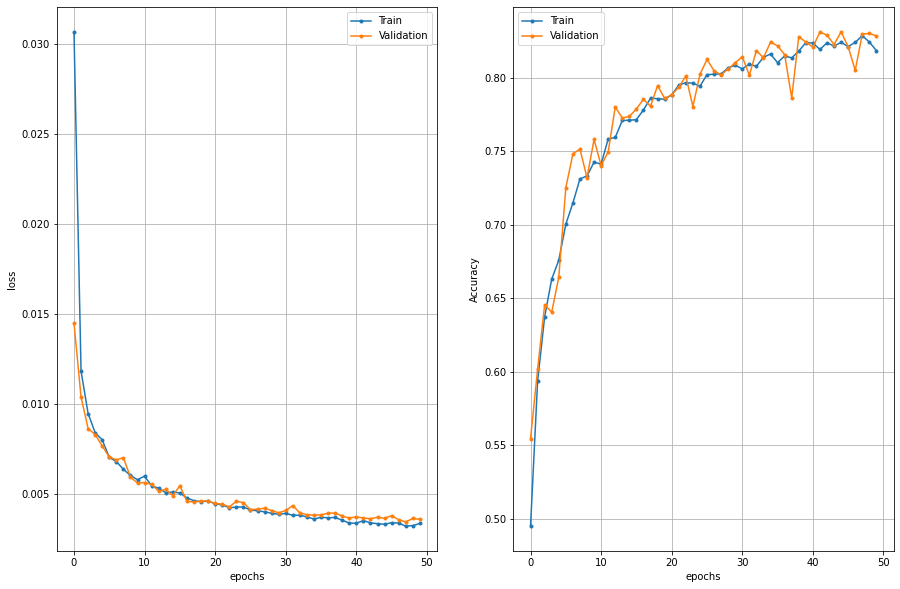

In [102]:
show_results(history)

In [103]:
encoded_imgs = autoencoder.encoder(test_dataset).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

with open('drive/MyDrive/Colab Notebooks/encoded_imgs.npy', 'wb') as f:
    np.save(f, encoded_imgs)

In [104]:
print('Sample encoded: ', encoded_imgs.shape)
print('Sample decoded: ', decoded_imgs.shape)
print('comression: ', decoded_imgs.shape[1]*decoded_imgs.shape[2]*decoded_imgs.shape[3]/encoded_imgs.shape[1])

Sample encoded:  (1437, 1000)
Sample decoded:  (1437, 54, 96, 3)
comression:  15.552


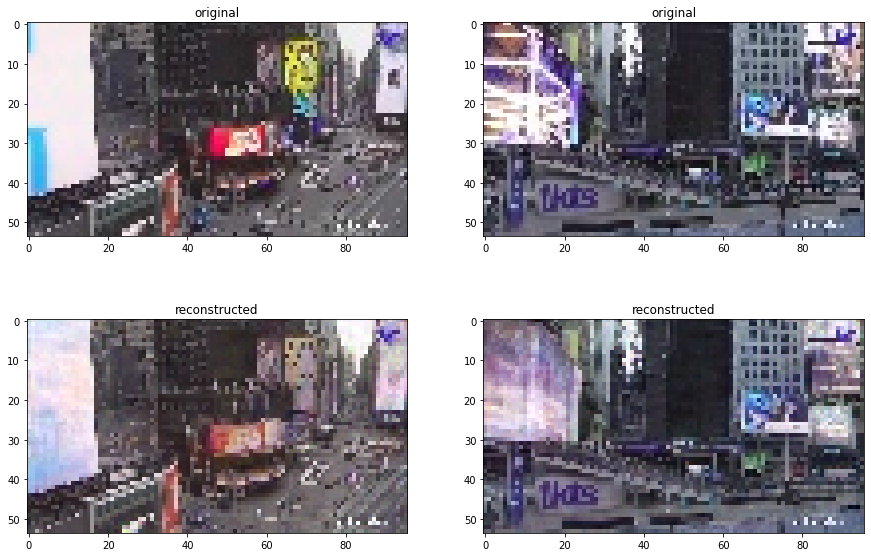

In [105]:
# Show random comparison
comparison(test_dataset, decoded_imgs, 2)

In [106]:
autoencoder.summary()

Model: "autoencoder_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 1000)              9990088   
                                                                 
 sequential_11 (Sequential)  (None, 54, 96, 3)         15567636  
                                                                 
Total params: 25,557,724
Trainable params: 25,557,724
Non-trainable params: 0
_________________________________________________________________


In [107]:
autoencoder.encoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, None, None, 16)    448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, None, None, 16)   0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 32)    4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, None)              0         
                                                                 
 dense_10 (Dense)            (None, 1000)            

In [108]:
autoencoder.decoder.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 15552)             15567552  
                                                                 
 reshape_5 (Reshape)         (None, 54, 96, 3)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 54, 96, 3)        84        
 ranspose)                                                       
                                                                 
Total params: 15,567,636
Trainable params: 15,567,636
Non-trainable params: 0
_________________________________________________________________
